In [1]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [2]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


### Exercise 1

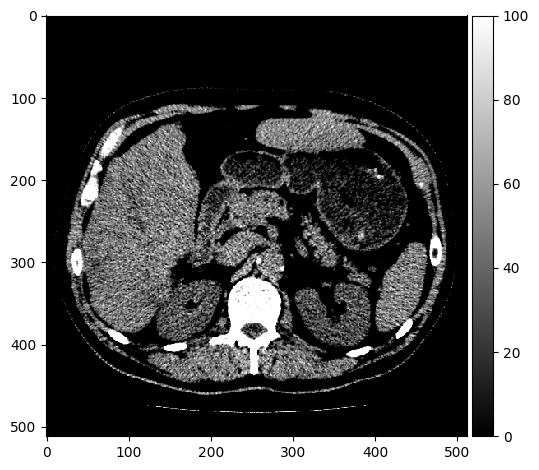

In [3]:
io.imshow(img, vmin=0, vmax=100, cmap='gray')
io.show()

In [4]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

### Exercise 2

In [5]:
mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)

print(f'Mean {mu_spleen} - Std {std_spleen}')

Mean 49.48026905829597 - Std 14.9970794143059


### Exercise 3

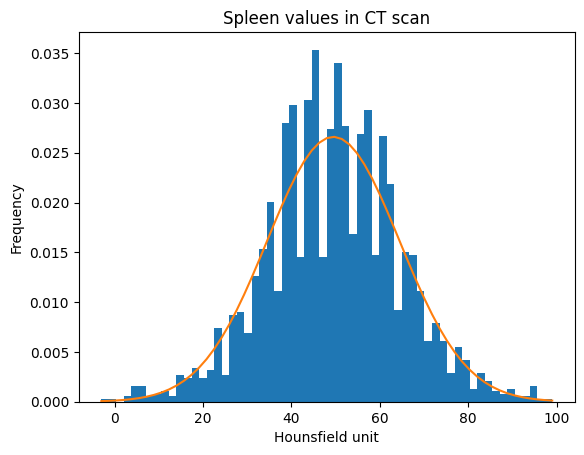

In [6]:
n, bins, patches = plt.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

### Exercise 4

In [7]:
def load_mask(mask_path):
    roi = io.imread(mask_path)
    mask = roi > 0
    return mask

def get_values(img, mask_path):
    mask = load_mask(mask_path)
    return img[mask]


paths = ['BoneROI.png', 'FatROI.png', 'KidneyROI.png', 'LiverROI.png', 'SpleenROI.png']
values = [get_values(img, in_dir + path) for path in paths]

In [8]:
def get_gaussian_distributions(values, min_hu = -200, max_hu = 1000):
    hu_range = np.arange(min_hu, max_hu, 1.0)
    mu = np.mean(values)
    std = np.std(values)
    pdf = norm.pdf(hu_range, mu, std)
    return pdf


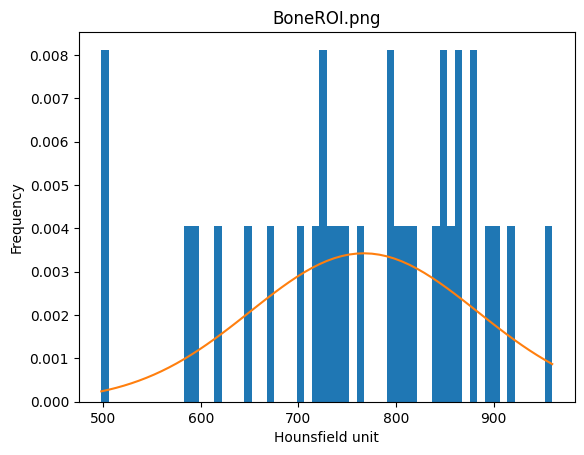

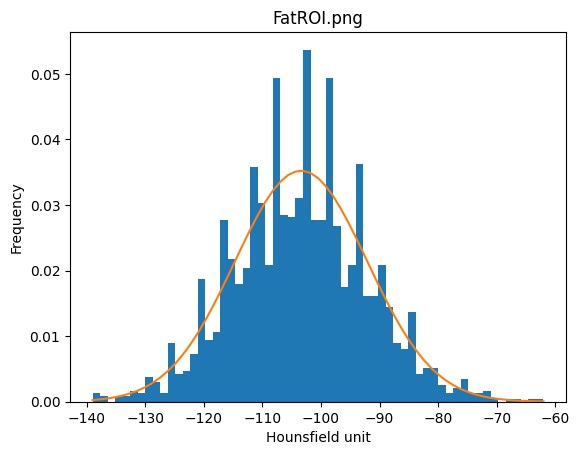

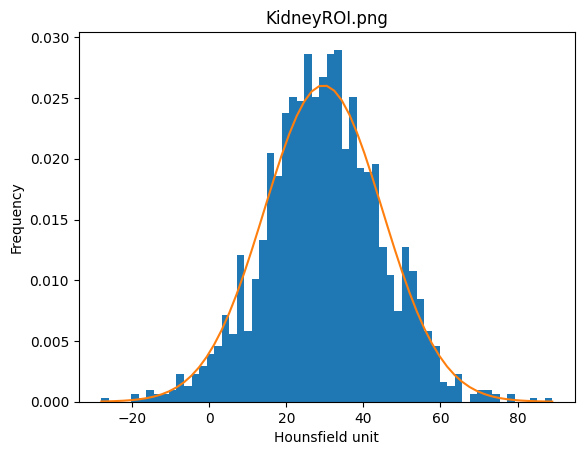

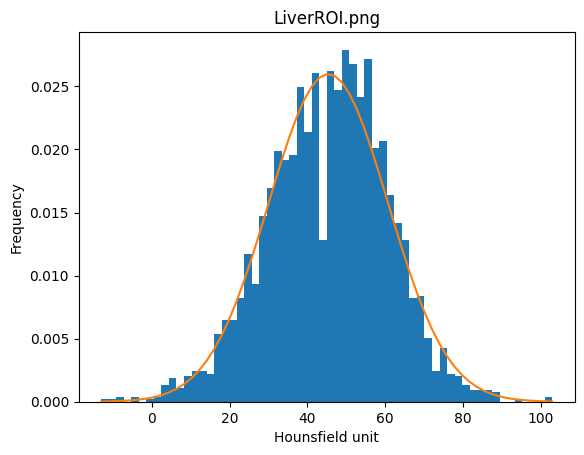

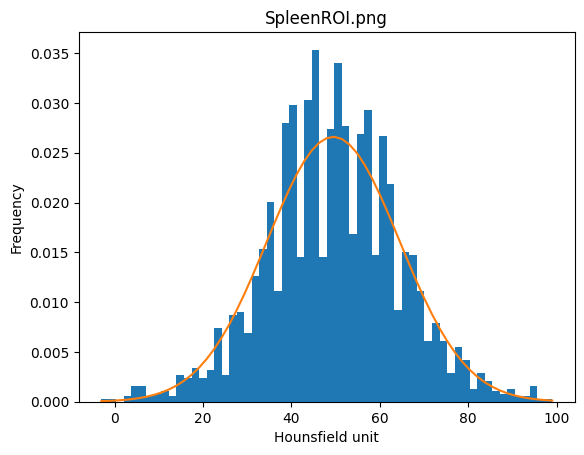

In [9]:
for value, name in zip(values, paths):
    n, bins, patches = plt.hist(value, 60, density=1)
    mu = np.mean(value)
    std = np.std(value)
    pdf = norm.pdf(bins, mu, std)
    plt.plot(bins, pdf)
    plt.xlabel('Hounsfield unit')
    plt.ylabel('Frequency')
    plt.title(name)
    plt.show()

### Exercise 5

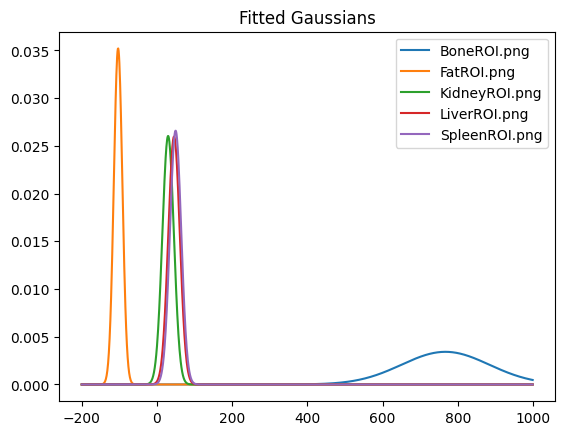

In [10]:
# Hounsfield unit limits of the plot
min_hu, max_hu = -200, 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdfs = [get_gaussian_distributions(value) for value in values]

for pdf, path in zip(pdfs, paths):
    plt.plot(hu_range, pdf, label=path)
    
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

### Exercise 6

We can differenciate intensity-wise the fat, soft tissues (kidney, liver, spleen) and bone

### Exercise 7

In [11]:
vals_soft_tissue = np.concatenate(values[-3:])
soft_tissue_mean = np.mean(vals_soft_tissue)
bone_mean = np.mean(values[0])
fat_mean = np.mean(values[1])

print(f'Soft tissue mean: {soft_tissue_mean} - Bone mean: {bone_mean} - Fat mean: {fat_mean}')

Soft tissue mean: 43.00880789673501 - Bone mean: 766.9375 - Fat mean: -103.39037725533078


In [12]:
t_fat_soft = (soft_tissue_mean + fat_mean)/2
t_bone_soft = (soft_tissue_mean + bone_mean)/2

### Exercise 8

In [13]:
t_background = -200
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_bone_soft)
bone_img = (img > t_bone_soft) & (img <= 1000)

### Exercise 9

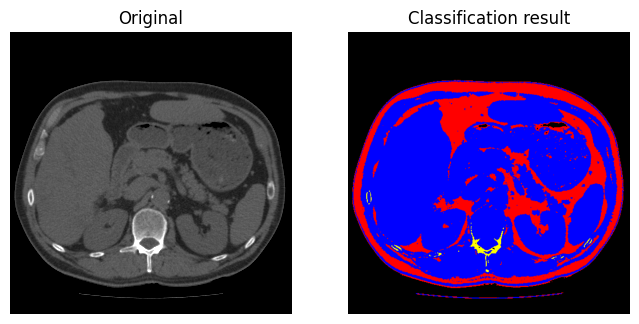

In [14]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

## Parametric pixel classification

### Exercise 9

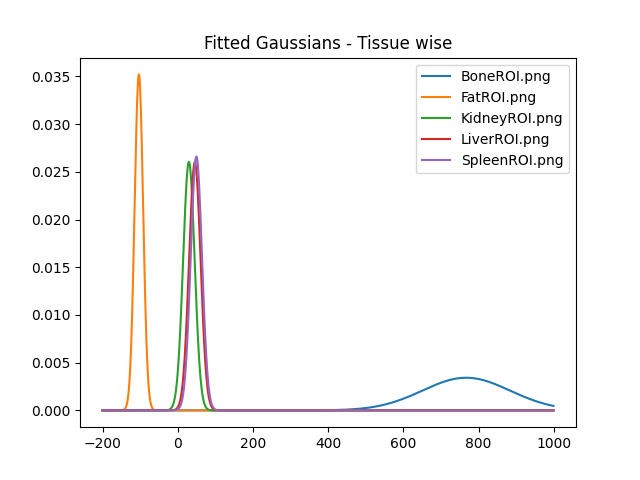

In [15]:
%matplotlib widget
# Hounsfield unit limits of the plot
min_hu, max_hu = -200, 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdfs = [get_gaussian_distributions(value) for value in values]

for pdf, path in zip(pdfs, paths):
    plt.plot(hu_range, pdf, label=path)
    
plt.title("Fitted Gaussians - Tissue wise")
plt.legend()
plt.show()

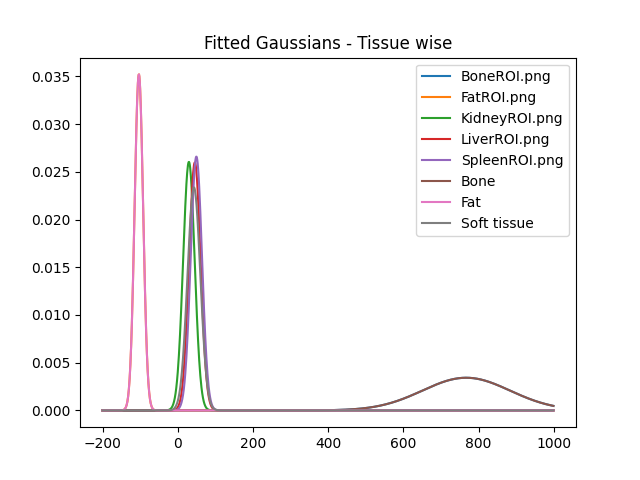

In [16]:
%matplotlib widget
# Hounsfield unit limits of the plot
min_hu, max_hu = -200, 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
values_3_classes = [values[0], values[1], vals_soft_tissue]
labels_3_classes = ['Bone', 'Fat', 'Soft tissue']

pdfs_3_classes = [get_gaussian_distributions(value) for value in values_3_classes]

for pdf, path in zip(pdfs_3_classes, labels_3_classes):
    plt.plot(hu_range, pdf, label=path)
    
plt.title("Fitted Gaussians - Tissue wise")
plt.legend()
plt.show()

### Exercise 10

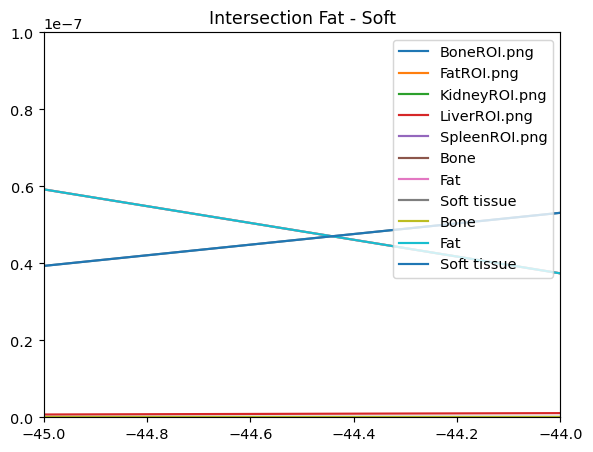

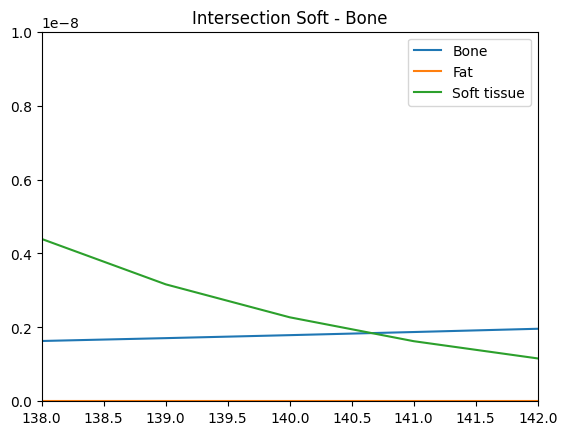

In [17]:
%matplotlib inline

# Manual intersection Fat - Soft
for pdf, path in zip(pdfs_3_classes, labels_3_classes):
    plt.plot(hu_range, pdf, label=path)
plt.title("Intersection Fat - Soft")
plt.xlim(-45, -44)
plt.ylim(0, 1e-7)
plt.legend()
plt.show()

# Manual intersection  Soft - Bone
for pdf, path in zip(pdfs_3_classes, labels_3_classes):
    plt.plot(hu_range, pdf, label=path)
    
plt.title("Intersection Soft - Bone")
plt.xlim(138, 142)
plt.ylim(0, 1e-8)
plt.legend()
plt.show()

In [18]:
# This cell helps you to define an 
# interval for the intersection of the gaussians. 
# Just change the test_value and run the cell again

mu_bone = np.mean(values_3_classes[0])
std_bone = np.std(values_3_classes[0])

mu_fat = np.mean(values_3_classes[1])
std_fat = np.std(values_3_classes[1])

mu_soft = np.mean(values_3_classes[2])
std_soft = np.std(values_3_classes[2])

# Soft vs Bone
test_value = 140
if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_bone, std_bone):
	print(f"For value {test_value} the class is soft tissue")
else:
	print(f"For value {test_value} the class is bone")
 
# Soft vs Fat
test_value = -45
if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_fat, std_fat):
	print(f"For value {test_value} the class is soft tissue")
else:
	print(f"For value {test_value} the class is fat")

For value 140 the class is soft tissue
For value -45 the class is fat


### Exercise 11

In [19]:
# Automatic intersection Fat - Soft
for test_value in np.linspace(mu_fat, mu_soft, 1000):
    if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_fat, std_fat):
        thres_fat_soft = test_value
        print(f"Fat - Soft threshold: {thres_fat_soft}")
        break

# Automatic intersection Soft - Bone
for test_value in np.linspace(mu_soft, mu_bone, 1000):
    if norm.pdf(test_value, mu_bone, std_bone) > norm.pdf(test_value, mu_soft, std_soft):
        thres_soft_bone = test_value
        print(f"Soft - Bone threshold: {thres_soft_bone}")
        break

Fat - Soft threshold: -44.332447709502425
Soft - Bone threshold: 140.83700953231136


## Object segmentation - The spleen finder

### Exercise 11

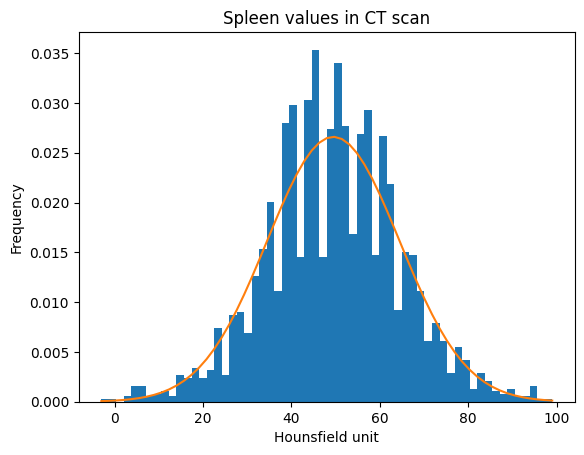

In [20]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array

path = "SpleenROI.png"
spleen_mask = load_mask(in_dir + path)
spleen_values = img[spleen_mask]

# fig, ax = plt.subplots()
# ax.imshow(spleen_mask)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
ax.plot(bins, pdf_spleen)
ax.set_xlabel('Hounsfield unit')
ax.set_ylabel('Frequency')
ax.set_title('Spleen values in CT scan')
plt.show()

t_1, t_2 = 20, 80

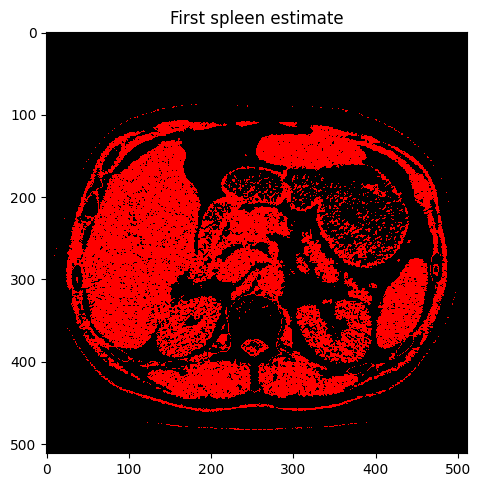

In [21]:
spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

### Exercise 12

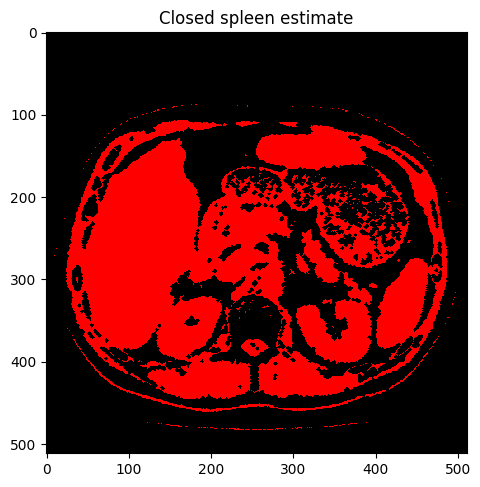

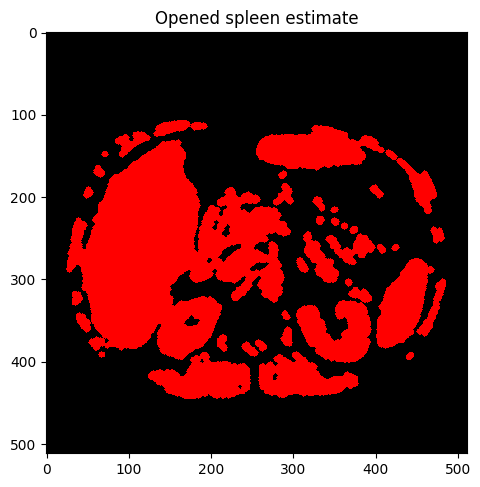

In [22]:
footprint = disk(2)
closed = binary_closing(spleen_estimate, footprint)
spleen_label_colour = color.label2rgb(closed)

io.imshow(spleen_label_colour)
plt.title("Closed spleen estimate")
io.show()

footprint = disk(4)
opened = binary_opening(closed, footprint)
spleen_label_colour = color.label2rgb(opened)
io.imshow(spleen_label_colour)
plt.title("Opened spleen estimate")
io.show()

### Exercise 12

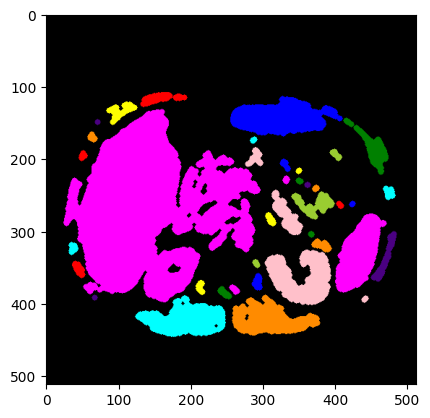

In [23]:
label_img = measure.label(opened)
im_blob = label2rgb(label_img)

plt.imshow(im_blob)
plt.show()

### Exercise 13

In [24]:
# Inspect the properties first 
region_props = measure.regionprops(label_img)

areas = np.array([prop.area for prop in region_props])
print(areas)
# plt.hist(areas, bins=50)
# plt.show()

perimeters = np.array([prop.perimeter for prop in region_props])
print(perimeters)

[  738.  5443.   654. 39829.  1387.    49.   146.    74.   387.   169.
   130.   164.    60.    91.    78.    58.    79.   251.  1218.  1094.
    85.    60.   189.  4513.    64.   764.   336.   183.  4431.    93.
   281.   262.   195.   134.   209.    49.  4054.  4431.    71.]
[ 167.2670273   437.7300141   146.99494937 2219.89480324  243.70562748
   24.97056275   46.52691193   31.21320344   98.12489168   52.76955262
   43.69848481   53.35533906   27.79898987   34.627417     31.79898987
   26.97056275   31.79898987   65.59797975  194.59292911  214.39191899
   34.04163056   27.79898987   56.18376618  321.30360723   28.38477631
  183.37972568   80.81118318   54.76955262  417.28636329   36.04163056
   69.254834     67.84062043   58.18376618   44.52691193   58.42640687
   24.97056275  404.21529548  396.55844123   30.627417  ]


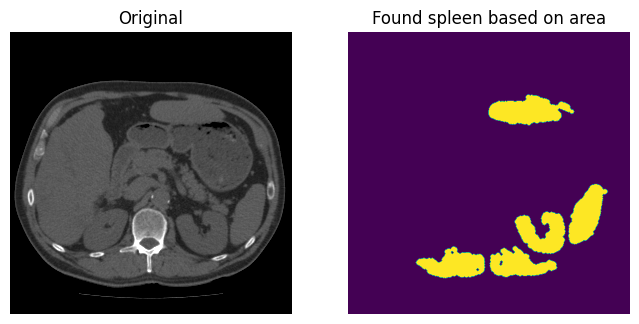

In [25]:
min_area = 2000
max_area = 10000

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')


### Exercise 14

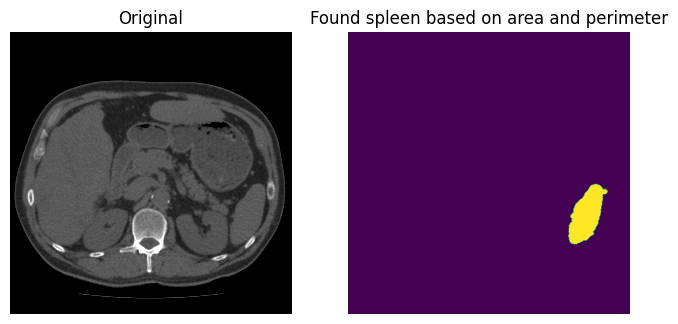

In [26]:
min_area = 2000
max_area = 10000
min_perimeter = 100
max_perimeter = 350

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
	# Find the areas that do not fit our criteria
	crit1 = region.area > max_area or region.area < min_area
	crit2 = region.perimeter > max_perimeter or region.perimeter < min_perimeter
	if crit1 or crit2:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
  
# Create binary image from the filtered label image
i_area_perimeter = label_img_filter > 0
show_comparison(img, i_area_perimeter, 'Found spleen based on area and perimeter')

### Exercise 15

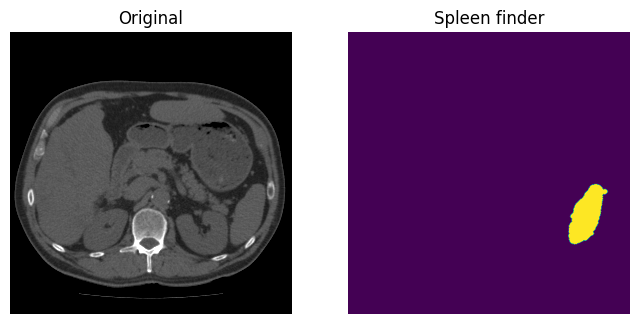

In [27]:
def spleen_finder(img):
    t_1, t_2 = 20, 80
    spleen_estimate = (img > t_1) & (img < t_2)

    footprint = disk(2)
    closed = binary_closing(spleen_estimate, footprint)
    footprint = disk(4)
    opened = binary_opening(closed, footprint)

    label_img = measure.label(opened)
    region_props = measure.regionprops(label_img)

    min_area = 2000
    max_area = 10000
    min_perimeter = 100
    max_perimeter = 350

    # Create a copy of the label_img
    label_img_filter = label_img.copy()
    for region in region_props:
        # Find the areas that do not fit our criteria
        crit1 = region.area > max_area or region.area < min_area
        crit2 = region.perimeter > max_perimeter or region.perimeter < min_perimeter
        if crit1 or crit2:
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    
    # Create binary image from the filtered label image
    i_area_perimeter = label_img_filter > 0
    
    return i_area_perimeter

spleen_estimate = spleen_finder(img)
show_comparison(img, spleen_estimate, 'Spleen finder')

### Exercise 16

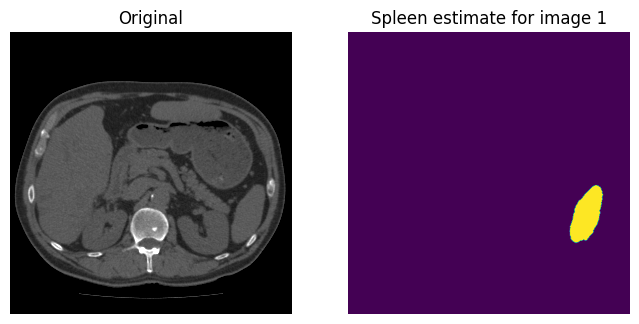

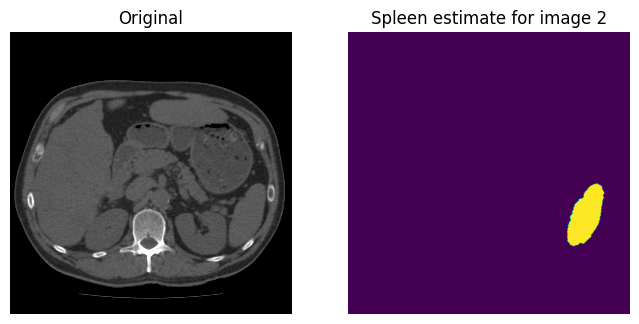

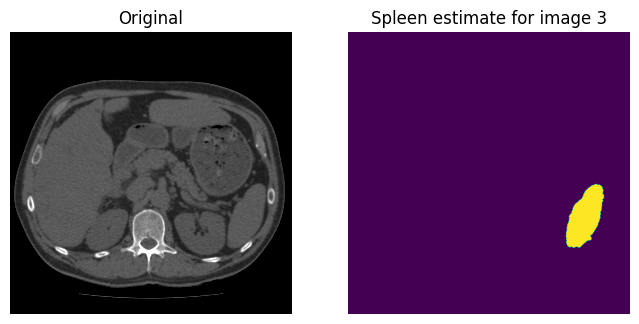

In [28]:
def load_dcm(path):
    ct = dicom.read_file(path)
    img = ct.pixel_array
    return img

for i in range(1, 4):
    path = f"data/Validation{i}.dcm"
    img = load_dcm(path)
    spleen_estimate = spleen_finder(img)
    show_comparison(img, spleen_estimate, f"Spleen estimate for image {i}")

### Exercise 17

In [29]:
def dice_score(img, gt_bin):
    # Calculate the dice score
    dice_score = 1 - distance.dice(img.ravel(), gt_bin.ravel())
    return dice_score

for i in range(1, 4):
    path = f"data/Validation{i}.dcm"
    img = load_dcm(path)
    spleen_estimate = spleen_finder(img)
    spleen_gt = load_mask(f"data/Validation{i}_spleen.png")
    dice = dice_score(spleen_estimate, spleen_gt)
    print(f"Dice score for validation image {i}: {dice:.3f}")

Dice score for validation image 1: 0.956
Dice score for validation image 2: 0.962
Dice score for validation image 3: 0.972


### Exercise 18

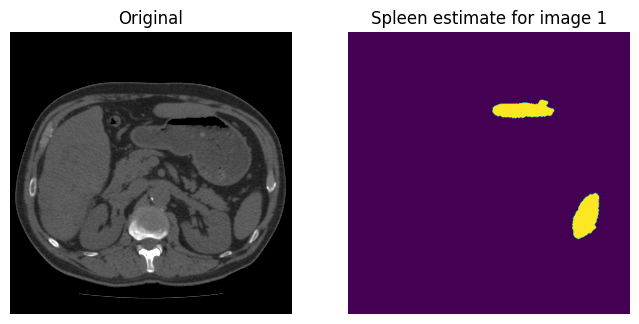

Dice score for test image 1: 0.650


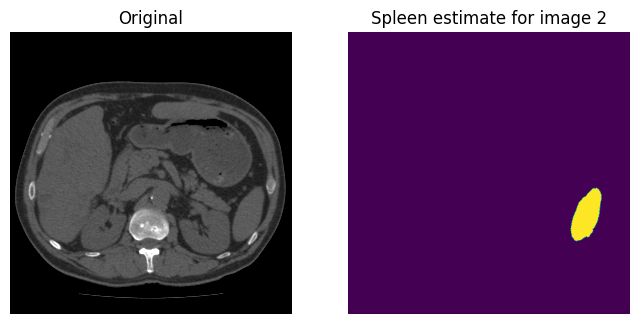

Dice score for test image 2: 0.952


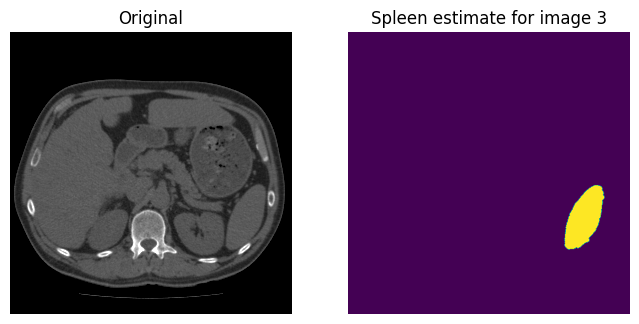

Dice score for test image 3: 0.967


In [30]:
for i in range(1, 4):
    path = f"data/Test{i}.dcm"
    img = load_dcm(path)
    spleen_estimate = spleen_finder(img)
    spleen_gt = load_mask(f"data/Test{i}_spleen.png")
    dice = dice_score(spleen_estimate, spleen_gt)
    show_comparison(img, spleen_estimate, f"Spleen estimate for image {i}")
    print(f"Dice score for test image {i}: {dice:.3f}")